# GARCH
- The purpose of this section is to manually calculate the parameters for a GARCH model.  
- This example data is pulled from [Vinegar Labs](https://sites.google.com/view/vinegarhill-financelabs), which in turn pulls the example from John Hull's classic "Options, Futures, and Other Derivatives"

In [8]:
import pandas as pd

df = pd.read_excel("SP_Data.xlsx")
df.head()

,Date,Price,Returns
0,2005-07-18,1221.13,0.000000
1,2005-07-19,1229.35,0.006731
2,2005-07-20,1235.20,0.004759
3,2005-07-21,1227.04,-0.006606
4,2005-07-22,1233.68,0.005411


## Overview of Process:  
Before building the model, we'll provide a high level overview of the process:  
- Create columns for Variance and Likelihood
- step 2
- step 3

In [9]:
# Create function which will be passed to scipy optimize.minimize
def opt_func(params, df):
    alpha, beta, omega = params
    
    # Create variance column
    df.loc[:,'Variance'] = 0
    df.loc[2,'Variance'] = df.loc[1,'Returns']**2 # Only the "first" observation is squared like this
    for i in range(3,len(df)):
        df.loc[i,'Variance'] = omega + (alpha * df.loc[i-1,'Returns']**2) + (beta * df.loc[i-1,'Variance'])
    
    # Create likelihood column
    df.loc[:,'Likelihood'] = -np.log(df.loc[2:,'Variance']) - (df.loc[2:,'Returns']**2 / df.loc[2:,'Variance'])

    return -df.loc[:,'Likelihood'].sum() #this is what we're minimizing (negative sign out front for minimization)

In [10]:
# Create guesses
alpha = 0.1
beta = 0.9
omega = 0.0001

guesses = (alpha, beta, omega)

In [15]:
result = minimize(opt_func, guesses, method='Nelder-Mead', args = df)                

/usr/local/lib/python3.9/site-packages/pandas/core/series.py:726: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [16]:
result.x

array([8.33801676e-02, 9.10144299e-01, 1.34575675e-06])

**The likelihood_sum and the alpha, beta, and omega parameters match the output from the arch_model output and table 22.1 from Options, Futures and Other Derivatives**

In [14]:
print(f"{likelihood_sum:,.2f}", " <<< the sum of the likelihood column")
print(f"{alpha:.5f}", ", ", f"{beta:.5f}", ", ", f"{omega:.6f}", ", ", "<<< alpha, beta, omega")

NameError: name 'likelihood_sum' is not defined

You can jump to section 3, "GARCH Model -- Validation", to verify the manual calculations for alpha, beta, and omega match the output from Hull and from the arch_model package.

# Using GARCH to Predict Future Prices

# GARCH Model -- Validation
- The purpose of this section is to validate that our manual results match different "sources of truth"

## Validation: Using arch_model
- [documentation](https://arch.readthedocs.io/en/latest/univariate/generated/generated/arch.univariate.base.ARCHModel.fit.html?highlight=.fit)

In [13]:
from arch import arch_model
model = arch_model(df['Returns']*100, mean='Zero', vol='GARCH', p=1, o=0, q=1)
model_fit = model.fit(disp='off')
print(model_fit.summary())

                       Zero Mean - GARCH Model Results                        
Dep. Variable:                Returns   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.001
Vol Model:                      GARCH   Log-Likelihood:               -1941.10
Distribution:                  Normal   AIC:                           3888.20
Method:            Maximum Likelihood   BIC:                           3903.67
                                        No. Observations:                 1279
Date:                Sun, Nov 22 2020   Df Residuals:                     1276
Time:                        21:01:29   Df Model:                            3
                               Volatility Model                              
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega          0.0134  6.896e-03      1.937  5.272e-02 

## Validation: Output from Table 22.1 in Options, Futures, and Other Derivatives (Hull)
- The manual garch parameter estimation and the GARCH function both match the output from Hull

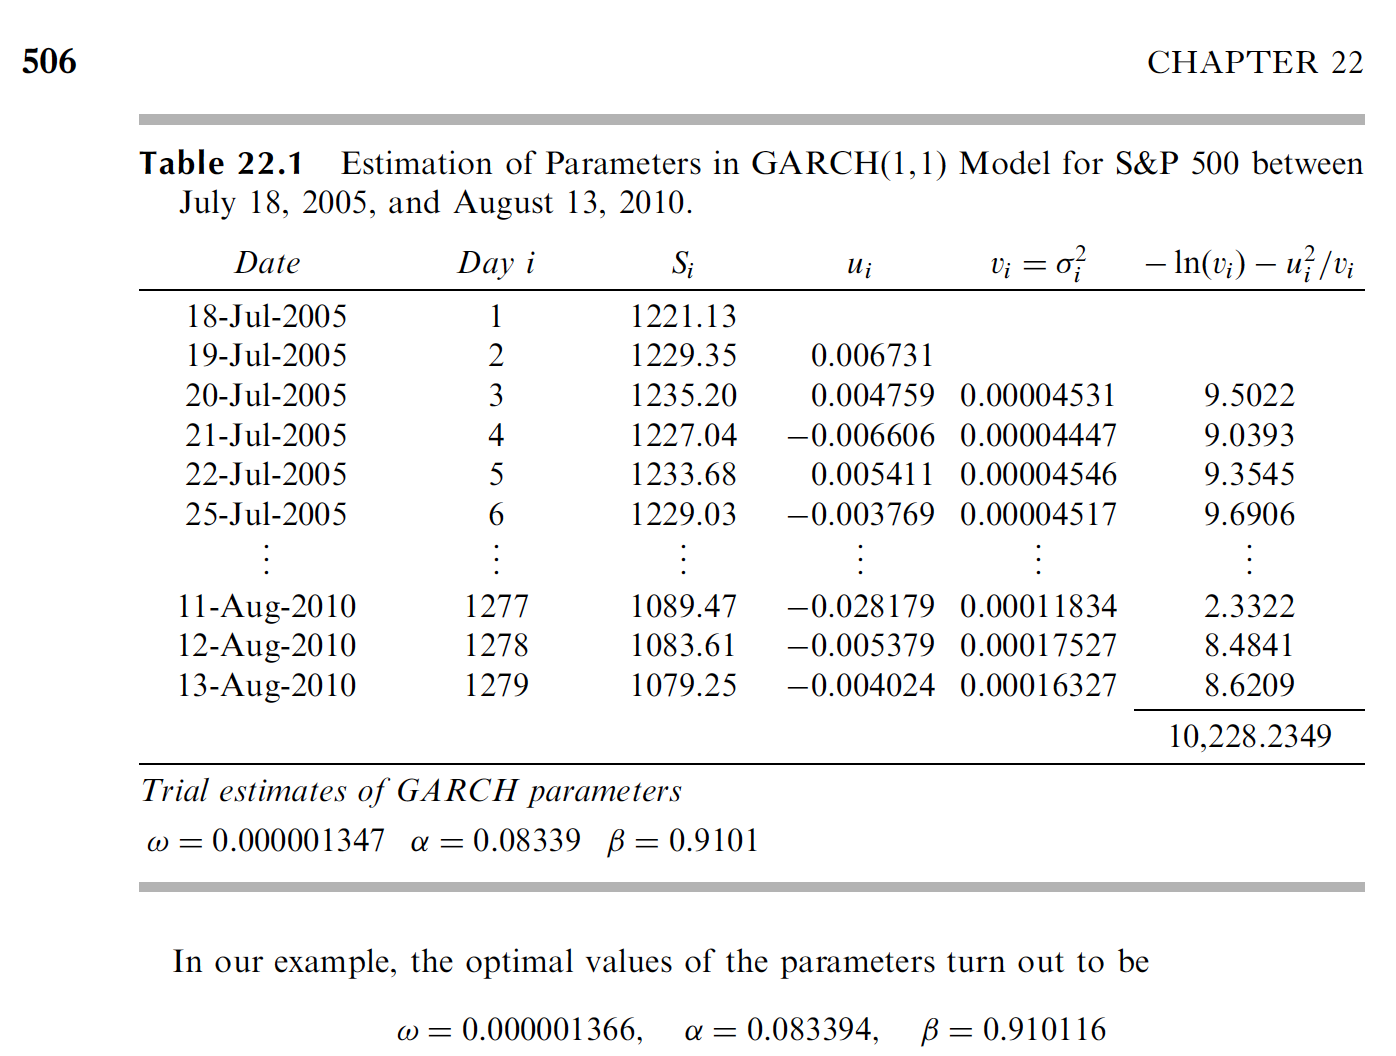

In [12]:
from IPython.display import Image
Image(filename='Hull - Table 22.1.png') 

# Nelder Mead Method from Scratch

**See notebook titled "Nelder Mead" in the  "Optimization" section**

# Misc Code

## Validate: output from arch_model (e.g. standard error, t, p, etc)

## scipy minimize example

In [1]:
from scipy.optimize import minimize, rosen
import math

In [6]:
# define function
def f(x):
    x1 = x[0]# pack the variables into a single array for scipy.minimize
    x2 = x[1]
    x3 = x[2]
    return -8*x1 - 10*x2 - 7*x3

# initial guess
x0 = np.array([0,0,0])

# constraints
def constraint1(x):
    return -x[0] - 3*x[1] - 2*x[2] + 10

def constraint2(x):
    return -x[0] - 5*x[1] - x[2] +8

def constraint3(x):
    return x[0]

def constraint4(x):
    return x[1]

def constraint5(x):
    return x[2]

con1 = {'type':'ineq', 'fun':constraint1}
con2 = {'type':'ineq', 'fun':constraint2}
con3 = {'type':'ineq', 'fun':constraint3}
con4 = {'type':'ineq', 'fun':constraint4}
con5 = {'type':'ineq', 'fun':constraint5}

cons = [con1, con2, con3, con4, con5]


minimize(f, x0, method='SLSQP', constraints = cons, options={'disp':True, 'maxiter':600})                

Optimization terminated successfully    (Exit mode 0)
            Current function value: -63.99999999959101
            Iterations: 4
            Function evaluations: 16
            Gradient evaluations: 4


     fun: -63.99999999959101
     jac: array([ -7.99999952, -10.        ,  -7.        ])
 message: 'Optimization terminated successfully'
    nfev: 16
     nit: 4
    njev: 4
  status: 0
 success: True
       x: array([ 8.00000000e+00, -4.41662012e-12, -8.69437855e-12])